In [1]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

C:\Users\ASUS\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import os
import pandas as pd
# read data
df_movies = pd.read_csv(
    'movies.csv',
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    'ratings.csv',
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
print(df_movies.info())
print(df_ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 2 columns):
movieId    58098 non-null int32
title      58098 non-null object
dtypes: int32(1), object(1)
memory usage: 681.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
userId     int32
movieId    int32
rating     float32
dtypes: float32(1), int32(2)
memory usage: 317.6 MB
None


In [4]:
print(df_movies.head())
print(df_ratings.head())

   movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)
   userId  movieId  rating
0       1      307     3.5
1       1      481     3.5
2       1     1091     1.5
3       1     1257     4.5
4       1     1449     4.5


In [5]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 283228 unique users and 53889 unique movies in this data set


In [6]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


In [7]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
                                          verify_integrity = True).sort_index()
df_ratings_cnt

,count
0.0,15235120248
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


In [8]:
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,15235120248,23.446869
0.5,442388,12.999943
1.0,886233,13.694735
1.5,441354,12.997603
2.0,1850627,14.431035
2.5,1373419,14.132814
3.0,5515668,15.523103
3.5,3404360,15.040568
4.0,7394710,15.816275
4.5,2373550,14.679897


Text(0, 0.5, 'number of ratings')

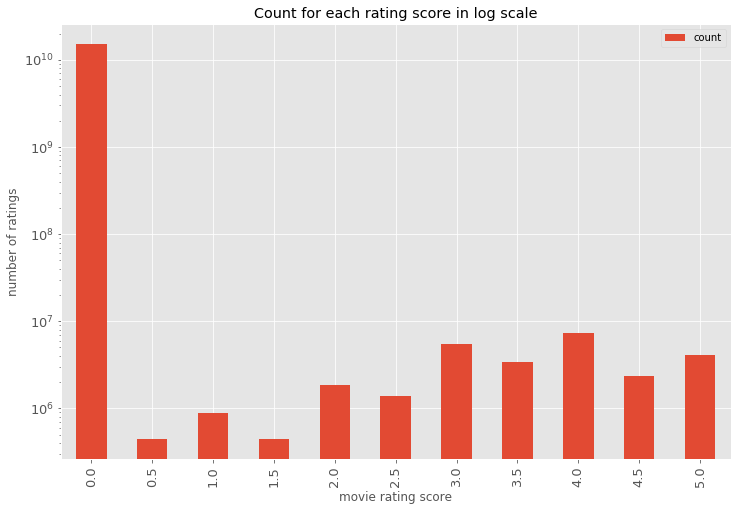

In [9]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index':'rating score'}).plot(
        x='rating score',
        y='count',
        kind='bar',
        figsize=(12,8),
        title='Count for each rating score in log scale',
        logy=True,
        fontsize=13)
ax.set_xlabel('movie rating score')
ax.set_ylabel('number of ratings')

In [10]:
#get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


Text(0, 0.5, 'number of rating')

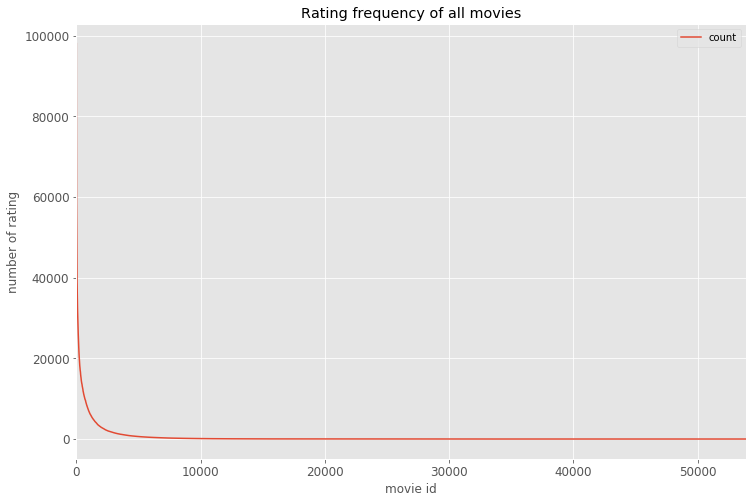

In [11]:
ax = df_movies_cnt.sort_values('count', ascending=False).reset_index(drop=True).plot(figsize=(12,8),
                                                                                    title='Rating frequency of all movies',
                                                                                     fontsize=12
                                                                                    )
ax.set_xlabel('movie id')
ax.set_ylabel('number of rating')

Text(0, 0.5, 'number of ratings in log scale')

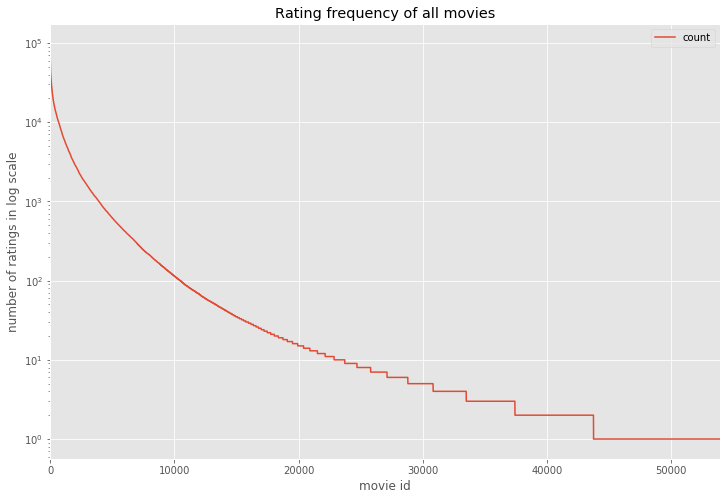

In [12]:
ax = df_movies_cnt.sort_values('count', ascending=False).reset_index(drop=True).plot(figsize=(12,8),
                                                                                    title='Rating frequency of all movies',
                                                                                    logy=True)
ax.set_xlabel('movie id')
ax.set_ylabel('number of ratings in log scale')

In [13]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    97999.0
0.95     1855.0
0.90      531.0
0.85      205.0
0.80       91.0
0.75       48.0
0.70       28.0
0.65       18.0
Name: count, dtype: float64

In [14]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping unpopular movies:  (27430748, 3)


In [15]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,16
2,15
3,11
4,736
5,72


Text(0, 0.5, 'number of ratings')

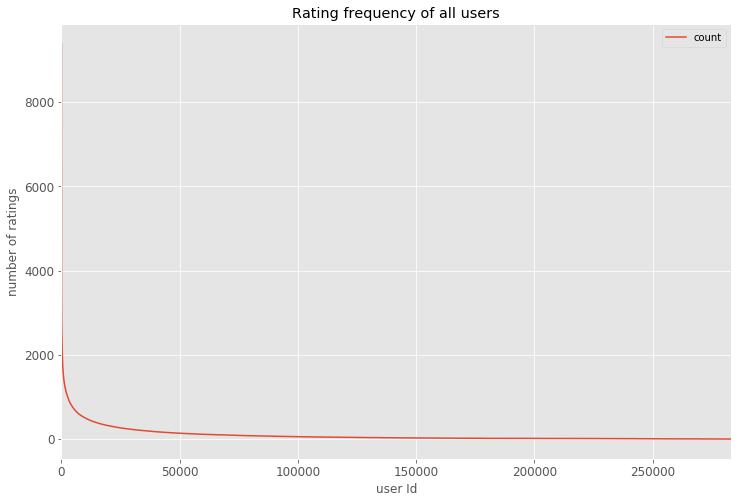

In [16]:
#plotting rating frequency of all movie
ax = df_users_cnt.sort_values('count', ascending=False).reset_index(drop=True).plot(figsize=(12,8), 
                                                                                    title='Rating frequency of all users',
                                                                                   fontsize=12)
ax.set_xlabel('user Id')
ax.set_ylabel('number of ratings')

In [17]:
df_users_cnt['count'].quantile(np.arange(1,0.5,-.05))

1.00    9384.0
0.95     403.0
0.90     239.0
0.85     164.0
0.80     121.0
0.75      94.0
0.70      73.0
0.65      58.0
0.60      47.0
0.55      37.0
Name: count, dtype: float64

In [18]:
#filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count>=@ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data : ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users : ', df_ratings_drop_users.shape)

shape of original ratings data :  (27753444, 3)
shape of ratings data after dropping both unpopular movies and inactive users :  (24178982, 3)


In [19]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [36]:
movie_user_mat_sparse

<13360x109483 sparse matrix of type '<class 'numpy.float32'>'
	with 24178982 stored elements in Compressed Sparse Row format>

In [32]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [33]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [37]:
my_favorite = 'Titanic'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Titanic
Found possible matches in our database: ['Titanic (1953)', 'Titanic (1997)', 'Titanica (1992)']

Recommendation system start to make inference
......

Recommendations for Titanic:
1: Jaws (1975), with distance of 0.8694027066230774
2: Lethal Weapon (1987), with distance of 0.8685601949691772
3: Romancing the Stone (1984), with distance of 0.8664530515670776
4: Patriot Games (1992), with distance of 0.8655809164047241
5: Backdraft (1991), with distance of 0.8655575513839722
6: Red Dawn (1984), with distance of 0.8647329211235046
7: Superman (1978), with distance of 0.8645155429840088
8: Presidio, The (1988), with distance of 0.8638623952865601
9: Thelma & Louise (1991), with distance of 0.8606460690498352
10: Night to Remember, A (1958), with distance of 0.845362663269043


In [35]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))


There is about 98.35% of ratings in our data is missing
